# Today's goals

- **Sprint 1: Scrubbing**
    - ~~Calculate deltas~~
    - Handle inconsistent data
    - Standardize time periods
- **Sprint 2: Exploratory analysis**
    - Most traffic on average (by day of week): choose top 20 areas
    - Traffic flows each time period
    - Do the days change over time
    - Get it on a map: try GeoPandas
    - Tech hubs
- **Sprint 3: External data**
    - NYC Census, median income
    - Safety? 
    - Number of nearby technology companies
- **Sprint 4: Presentation** 
    - Make initial recommendations
    - Throw some graphs up on the slides
    - Start putting presentation together
    
Separate
    
- Morning vs evening ridership
- Which stations most busy in the morning
- Flow
    

# To do

- Use Pandas-Profiling

In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)

# Load data from txt files

In [3]:
# def get_data(folder):
#     """
#     Reads in turnstile data from a specified folder in Data
    
#     Input: turnstile data file i.e. 2016-2017_turnstile_data
#     Output: a DataFrame with all rows from all files in folder
#     """
    
#     col_names = ['C/A',
#                  'UNIT',
#                  'SCP',
#                  'STATION',
#                  'LINENAME',
#                  'DIVISION',
#                  'DATE',
#                  'TIME',
#                  'DESC',
#                  'ENTRIES',
#                  'EXITS                                                               ']

#     ## absolute path to Data folder
#     data_dir = os.getcwd()+"/Data/" 
    
#     return_df = pd.DataFrame(columns=col_names)
#     for file in os.listdir(data_dir+folder):
#         if not file.startswith('.'):
#             file_path = "Data/"+folder+'/'+file
#             return_df = pd.concat([return_df, pd.read_csv(file_path)],axis=0)
            
#     return_df.rename(columns={return_df.columns[10]:'EXITS'},inplace=True)
    
#     return(return_df)

# df = get_data("2016-2019_turnstile_data")
# df['ENTRIES'] = df['ENTRIES'].astype(np.int)
# df['EXITS'] = df['EXITS'].astype(np.int)

# df.shape

In [4]:
# df.to_csv("2016-2019_turnstile_data.csv", index=False)

# Load data from csv

In [5]:
# df = pd.read_csv("2016-2019_turnstile_data.csv")

# Load data from pickle

In [6]:
# df.to_pickle('data.pkl')
df = pd.read_pickle('data.pkl')
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,00:00:00,REGULAR,6989774,2370411
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,04:00:00,REGULAR,6989795,2370413
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,08:00:00,REGULAR,6989813,2370436
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,12:00:00,REGULAR,6989924,2370512
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,16:00:00,REGULAR,6990200,2370573


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10303675 entries, 0 to 10303674
Data columns (total 11 columns):
C/A         object
UNIT        object
SCP         object
STATION     object
LINENAME    object
DIVISION    object
DATE        object
TIME        object
DESC        object
ENTRIES     int64
EXITS       int64
dtypes: int64(2), object(9)
memory usage: 864.7+ MB


# Extract date and time features

In [8]:
date = pd.to_datetime(df['DATE'], format='%m/%d/%Y')
time = pd.to_datetime(df['TIME'], format='%H:%M:%S')

df['year'] = date.dt.year
df['month'] = date.dt.month
df['day_of_week'] = date.dt.weekday
df['hour'] = time.dt.hour
df['minute'] = time.dt.minute

df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,year,month,day_of_week,hour,minute
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,00:00:00,REGULAR,6989774,2370411,2019,3,5,0,0
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,04:00:00,REGULAR,6989795,2370413,2019,3,5,4,0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,08:00:00,REGULAR,6989813,2370436,2019,3,5,8,0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,12:00:00,REGULAR,6989924,2370512,2019,3,5,12,0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,16:00:00,REGULAR,6990200,2370573,2019,3,5,16,0


# Calculate number of entries in each time period (`entries_delta`)

- Group DataFrame by turnstile and sort by date
- Define an appropriate time period
- Check for inconsistent data

In order to identify unique turnstiles, we use two key definitions from the [MTA transit toolkit](http://transitdatatoolkit.com/lessons/subway-turnstile-data/):

- `UNIT`: The remote unit is a collection of turnstiles... there can be multiple remote units one station
- `SCP`: Subunit channel position represents a turnstile... the same number can be used at different stations

Together, `UNIT` and `SCP` make a unique identifier for NYC turnstiles. 

In [9]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,year,month,day_of_week,hour,minute
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,00:00:00,REGULAR,6989774,2370411,2019,3,5,0,0
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,04:00:00,REGULAR,6989795,2370413,2019,3,5,4,0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,08:00:00,REGULAR,6989813,2370436,2019,3,5,8,0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,12:00:00,REGULAR,6989924,2370512,2019,3,5,12,0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,16:00:00,REGULAR,6990200,2370573,2019,3,5,16,0


Want to sort by `UNIT` and `SCP`, then make everything chronological.

[How to apply a rolling function, by group.](https://chrisalbon.com/python/data_wrangling/pandas_apply_function_by_group/)

In [10]:
df_clean = df.sort_values(['UNIT','SCP','DATE','TIME'], ascending=[True,True,False,True]).reset_index(drop=True)
turnstiles = df_clean.groupby(['UNIT', 'SCP', 'year'], sort=False)

df_clean['entries_deltas'] = turnstiles['ENTRIES'].apply(lambda x: x.rolling(2).apply(lambda x: x[1] - x[0], raw=True))
df_clean['exits_deltas'] = turnstiles['EXITS'].apply(lambda x: x.rolling(2).apply(lambda x: x[1] - x[0], raw=True))
df_clean['is_weekday'] = (df_clean['day_of_week'] != 5) & (df_clean['day_of_week'] != 6)

# could pickle this later
weekdays = df_clean.loc[(df_clean['day_of_week'] != 5) & (df_clean['day_of_week'] != 6)]

#  Filter and handle anomalies in deltas

Our filtering criteria:

- Greater than 4800 entrances or exits in a time period = anomaly
- Negative delta = anomaly

In [11]:
tot_anomalies = sum(weekdays['entries_deltas'] < 0)    \
    + sum(weekdays['exits_deltas'] < 0)    \
    + sum(weekdays['entries_deltas'] > 4800)    \
    + sum(weekdays['exits_deltas'] > 4800)

tot_anomalies

2279319

### Drop high anomalies

According to this criteria, we count 2.27m anomalies. What percentage of our data do we lose if we ignore the rows where there are more than 4800 entrances or exits?

In [13]:
to_drop = (weekdays['entries_deltas'] > 4800) | (weekdays['exits_deltas'] > 4800)
sum(to_drop)/len(weekdays)

0.0009385869291515109

We'll drop these rows for now, meaning we lose less than 0.1% of the data.

In [41]:
weekdays = weekdays[(weekdays['entries_deltas'] <= 4800) & (weekdays['exits_deltas'] <= 4800)]

### Impute negative anomalies

In [42]:
weekdays.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS', 'year', 'month', 'day_of_week', 'hour',
       'minute', 'entries_deltas', 'exits_deltas', 'is_weekday'],
      dtype='object')

# Data exploration

## Busiest overall

In [55]:
import seaborn as sns

In [49]:
weekdays.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS', 'year', 'month', 'day_of_week', 'hour',
       'minute', 'entries_deltas', 'exits_deltas', 'is_weekday'],
      dtype='object')

In [67]:
stations = weekdays.groupby(['STATION'],as_index=False)['entries_deltas','exits_deltas'].mean()

In [68]:
stations

,STATION,entries_deltas,exits_deltas
0,1 AV,-344.194,-370.454
1,103 ST,-268114.791,-215773.640
2,103 ST-CORONA,-338.434,-248.048
3,104 ST,-277.236,-296.502
4,110 ST,-306.967,-249.513
...,...,...,...
376,WOODLAWN,-220.435,-50.508
377,WORLD TRADE CTR,-439.035,-181.563
378,WTC-CORTLANDT,-57.338,-45.591
379,YORK ST,-553.657,-273.377


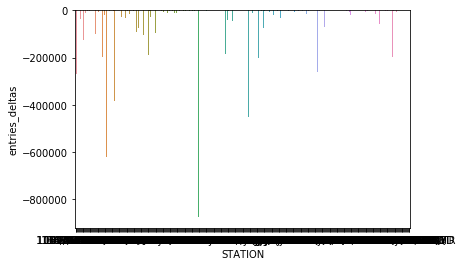

In [69]:
sns.barplot(stations['STATION'],stations['entries_deltas']);

In [ ]:
weekdays.groupby(['UNIT'])

In [21]:
df
df_clean.loc[1824560:1824575,:]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,year,month,day_of_week,hour,minute,entries_deltas,exits_deltas,is_weekday
1824560,R238,R046,00-03-01,GRD CNTRL-42 ST,4567S,IRT,03/15/2017,00:00:00,REGULAR,17883188,6945260,2017,3,2,0,0,-1.507e+06,-9.816e+05,True
1824561,R238,R046,00-03-01,GRD CNTRL-42 ST,4567S,IRT,03/15/2017,04:00:00,REGULAR,17883200,6945285,2017,3,2,4,0,1.200e+01,2.500e+01,True
1824562,R238,R046,00-03-01,GRD CNTRL-42 ST,4567S,IRT,03/15/2017,08:00:00,REGULAR,17883838,6945659,2017,3,2,8,0,6.380e+02,3.740e+02,True
1824563,R238,R046,00-03-01,GRD CNTRL-42 ST,4567S,IRT,03/15/2017,12:00:00,REGULAR,17886007,6946304,2017,3,2,12,0,2.169e+03,6.450e+02,True
1824564,R238,R046,00-03-01,GRD CNTRL-42 ST,4567S,IRT,03/15/2017,16:00:00,REGULAR,17886717,6947681,2017,3,2,16,0,7.100e+02,1.377e+03,True
1824565,R238,R046,00-03-01,GRD CNTRL-42 ST,4567S,IRT,03/15/2017,20:00:00,REGULAR,17888598,6949356,2017,3,2,20,0,1.881e+03,1.675e+03,True
1824566,R238,R046,00-03-01,GRD CNTRL-42 ST,4567S,IRT,03/15/2016,00:00:00,REGULAR,12149045,14181383,2016,3,1,0,0,-5.740e+06,7.232e+06,True
1824567,R238,R046,00-03-01,GRD CNTRL-42 ST,4567S,IRT,03/15/2016,04:00:00,REGULAR,12149239,14181393,2016,3,1,4,0,1.940e+02,1.000e+01,True
1824568,R238,R046,00-03-01,GRD CNTRL-42 ST,4567S,IRT,03/15/2016,08:00:00,REGULAR,12149859,14181876,2016,3,1,8,0,6.200e+02,4.830e+02,True
1824569,R238,R046,00-03-01,GRD CNTRL-42 ST,4567S,IRT,03/15/2016,12:00:00,REGULAR,12151684,14182998,2016,3,1,12,0,1.825e+03,1.122e+03,True


In [ ]:
df_clean['entries_']

In [ ]:
import matplotlib.pyplot as plt 
plt.barh(df_clean['entries_deltas'],.5)

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x117f33440> (for post_execute):


KeyboardInterrupt: 

Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x2690fcd40>
Traceback (most recent call last):
  File "/Users/collindching/anaconda3/envs/metis/lib/python3.7/site-packages/matplotlib/transforms.py", line 178, in <lambda>
    ref = weakref.ref(self, lambda ref, sid=id(self),
KeyboardInterrupt


- What to filter out by? How to catch anomalies?
   - Standard deviation
- Imputing: How many averages do we want? 
   - Per turnstile per hour

In [35]:
df['entries_delta'] = df['ENTRIES']    \
    .rolling(2)    \
    .apply(lambda x: get_dif(e2,e1) ,raw=True)

,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,year,month,day_of_week,hour,minute
0,4193389,A060,R001,00-00-00,WHITEHALL S-FRY,R1,BMT,05/27/2016,01:00:00,REGULAR,1770004,1646356,2016,5,4,1,0
1,4193390,A060,R001,00-00-00,WHITEHALL S-FRY,R1,BMT,05/27/2016,05:00:00,REGULAR,1770010,1646360,2016,5,4,5,0
2,4193391,A060,R001,00-00-00,WHITEHALL S-FRY,R1,BMT,05/27/2016,09:00:00,REGULAR,1770158,1646411,2016,5,4,9,0
3,4193392,A060,R001,00-00-00,WHITEHALL S-FRY,R1,BMT,05/27/2016,13:00:00,REGULAR,1770312,1646547,2016,5,4,13,0
4,4193393,A060,R001,00-00-00,WHITEHALL S-FRY,R1,BMT,05/27/2016,17:00:00,REGULAR,1770660,1646645,2016,5,4,17,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10303670,9819943,N702A,R572,01-03-04,96 ST-2 AVE,Q,IND,02/23/2019,04:00:00,REGULAR,973617,319683,2019,2,5,4,0
10303671,9819944,N702A,R572,01-03-04,96 ST-2 AVE,Q,IND,02/23/2019,08:00:00,REGULAR,973673,319707,2019,2,5,8,0
10303672,9819945,N702A,R572,01-03-04,96 ST-2 AVE,Q,IND,02/23/2019,12:00:00,REGULAR,973914,319740,2019,2,5,12,0
10303673,9819946,N702A,R572,01-03-04,96 ST-2 AVE,Q,IND,02/23/2019,16:00:00,REGULAR,974081,319779,2019,2,5,16,0


In [25]:
turnstiles = df.groupby(['UNIT', 'SCP'], sort=False)
len(turnstiles.groups)

5073

In [ ]:
df['entries_delta'] = df['ENTRIES']    \
    .rolling(2)    \
    .apply(lambda x: x[1]-x[0] if abs(x[1]-x[0]) < 5000 else np.nan ,raw=True)

In [69]:
turnstiles.sort_values()

AttributeError: Cannot access callable attribute 'sort_values' of 'DataFrameGroupBy' objects, try using the 'apply' method

# Develop method to count turnstile

In [57]:
sample_df = df[df['STATION'] == '59 ST']

In [63]:
sample_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [65]:
sample_df[['DATE','TIME','ENTRIES']]

,DATE,TIME,ENTRIES
0,03/23/2019,00:00:00,6989774
1,03/23/2019,04:00:00,6989795
2,03/23/2019,08:00:00,6989813
3,03/23/2019,12:00:00,6989924
4,03/23/2019,16:00:00,6990200
...,...,...,...
157647,03/09/2018,11:00:00,232801
157648,03/09/2018,12:12:19,232807
157649,03/09/2018,15:00:00,232818
157650,03/09/2018,19:00:00,232889


In [75]:
sample_df['ENTRIES']

0         6989774
1         6989795
2         6989813
3         6989924
4         6990200
           ...   
157647     232801
157648     232807
157649     232818
157650     232889
157651     232905
Name: ENTRIES, Length: 115306, dtype: int64

In [42]:
df.groupby(['STATION'])['ENTRIES'].mean()

STATION
59 ST    3.803133e+07
Name: ENTRIES, dtype: float64

In [ ]:
df.shape

In [8]:
# No missing values
df.isnull().sum()

C/A                                                                     0
UNIT                                                                    0
SCP                                                                     0
STATION                                                                 0
LINENAME                                                                0
DIVISION                                                                0
DATE                                                                    0
TIME                                                                    0
DESC                                                                    0
ENTRIES                                                                 0
EXITS                                                                   0
dtype: int64

In [76]:
df['C/A'].nunique()

751

## Reduce scope by plotting